# Semi-Supervised Learning of MNIST CNN
Jared Nielsen



# **Results**


### MNIST
`model_B` achieves 90.6% accuracy on `data_A` when `model_A` has 89.9% accuracy on `data_A`.  
`model_B` achieves 96.6% accuracy on `data_A` when `model_A` has 97.9% accuracy on `data_A`.

### Fashion-MNIST
`model_B` achieves 81.1% accuracy on `data_A` when `model_A` has 83.5% accuracy on `data_A`.  
`model_B` achieves 85.5% accuracy on `data_A` when `model_A` has 87.6% accuracy on `data_A`.

# **Notes**

### Terminology
`acc*` - The training accuracy when `model_A` is trained on all the labeled data.  
`acc1` - The training accuracy when `model_A` is trained on a subset of the labeled data.  
`acc2` - The unobserved test accuracy (on the unlabeled data) when `model_A` is trained on a subset of the labeled data.  
`acc3` - The accuracy on `data_A` when `model_B` is trained on `data_B_hat`.

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from mag.experiment import Experiment
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from tqdm import tqdm, tqdm_notebook
from time import sleep
import ray
from sklearn.metrics import confusion_matrix

import mnist_cnn
from mnist_cnn import Net, model_A_path, model_B_path
from utils import plot_confusion_matrix

tqdm_disable = True

### Load `dataset_A` and `dataset_B`

In [2]:
batch_size_train = 64
batch_size_test = 1000
learning_rate = 1e-3 #0.01
momentum = 0.5
log_interval = 10

if torch.cuda.is_available():
    print('using cuda')
    device = torch.device('cuda')
else:
    print('using cpu')
    device = torch.device('cpu')

random_seed = 1
# torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

root_dir = "../data/fashion-mnist/"
mnist_train = torchvision.datasets.FashionMNIST(root_dir, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

# ray.init(num_cpus=4, include_webui=False)

using cuda


### Train `model_A` on `dataset_A`

In [90]:
def train(model_A, optimizer_A, epoch, dataloader):
    model_A.train()
    for batch_idx, (data, target) in tqdm_notebook(enumerate(dataloader), desc='epoch {}'.format(epoch),
                                                  total=len(dataloader), disable=tqdm_disable):
        data, target = data.to(device), target.to(device)
        optimizer_A.zero_grad()
        output = model_A(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer_A.step()
        if batch_idx % log_interval == 0:
            torch.save(model_A.state_dict(), model_A_path)

def test(network, dataloader):
    network.eval()
    test_loss = 0
    correct = 0
    preds = []
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            preds.append(pred)
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(dataloader.dataset)
        acc = 100 * correct.item() / len(dataloader.dataset)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(dataloader.dataset), acc))
        
    preds = torch.cat(preds, dim=0)
    return acc, preds

def train_model_A(model_A, opt_A, dataloader, n_epochs):    
    for i_epoch in range(n_epochs):
        train(model_A=model_A, optimizer_A=opt_A, epoch=i_epoch,
              dataloader=dataloader)
        
def train_with_transfer_labels(model_A, model_B, optimizer_B, epoch, dataloader):
    model_A.eval()
    model_B.train()
    for batch_idx, (data, target) in tqdm_notebook(enumerate(dataloader), desc='epoch {}'.format(epoch),
                                                  total=len(dataloader), disable=tqdm_disable):
        data, target = data.to(device), target.to(device)
        target_hat = model_A(data)
        target_hat = torch.argmax(target_hat, dim=1)
        optimizer_B.zero_grad()
        output = model_B(data)
        loss_hat = F.nll_loss(output, target_hat)
        loss_hat.backward()
        optimizer_B.step()
        
        if batch_idx % log_interval == 0:
            torch.save(model_B.state_dict(), model_B_path)
            
def train_model_B(model_A, model_B, opt_B, dataloader, n_epochs):
    for i_epoch in range(n_epochs):
        train_with_transfer_labels(model_A=model_A, model_B=model_B, optimizer_B=opt_B,
                                  epoch=i_epoch, dataloader=dataloader)

# @ray.remote
def get_reverse_accuracy(pct, n_epochs):
    n_digits = len(mnist_train)
    train_size = int(n_digits * pct)
    test_size = n_digits - train_size
    dataset_A, dataset_B = random_split(mnist_train, [train_size, test_size])
    print("data_A: {}, data_B: {}".format(len(dataset_A), len(dataset_B)))
    loader_A, loader_B = [DataLoader(dataset, batch_size=batch_size_train, shuffle=False) 
                          for dataset in (dataset_A, dataset_B)]
    
    model_A = Net().to(device)
    opt_A = optim.SGD(model_A.parameters(), lr=learning_rate,
                     momentum=momentum)
    opt_A = optim.Adam(model_A.parameters(), lr=learning_rate)
    
    train_model_A(model_A=model_A, opt_A=opt_A, dataloader=loader_A, n_epochs=n_epochs)
    
    model_B = Net().to(device)
    opt_B = optim.SGD(model_B.parameters(), lr=learning_rate,
                     momentum=momentum)
    opt_B = optim.Adam(model_B.parameters(), lr=learning_rate)
    
    train_model_B(model_A=model_A, model_B=model_B, opt_B=opt_B,
                 dataloader=loader_B, n_epochs=n_epochs)
    
    
    
    acc1, predsA = test(network=model_A, dataloader=loader_A)
    acc3, predsB = test(network=model_B, dataloader=loader_A)
    return acc1, acc3, loader_A, predsA.cpu().numpy().flatten(), predsB.cpu().numpy().flatten()

def prediction_similarity(preds_A, preds_B):
    return (preds_A == preds_B).mean()

acc1, acc3, loaderA, predsA, predsB = get_reverse_accuracy(pct=0.50, n_epochs=10)
print("done")

data_A: 30000, data_B: 30000

Test set: Avg. loss: 0.3287, Accuracy: 26453/30000 (88.18%)


Test set: Avg. loss: 0.5429, Accuracy: 25577/30000 (85.26%)

done


Confusion matrix, without normalization
[[3601    7   19   52    1    2   19    0   11    0]
 [   6 2902    2   29    2    0    0    0    0    0]
 [  34    3 3281    7  300    9  141    0    7    0]
 [  59   31    5 2794   71    0    7    0    1    2]
 [   1    3   73   33 2872    0   51    0    8    0]
 [   1    0    2    2    0 2728    0  222   32   91]
 [ 123    3  113   18  176    0 1077    0   21    0]
 [   0    0    0    0    0    5    0 2738    1  102]
 [   8    1   30    8    9   16    6    3 2922    1]
 [   0    0    0    0    0    1    0   53    1 3040]]


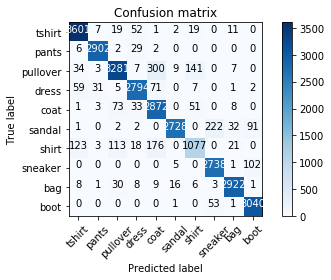

In [84]:
fmnist_labels = ["tshirt", "pants", "pullover", "dress", "coat",
                "sandal", "shirt", "sneaker", "bag", "boot"]

predsA, predsB = predsA.flatten(), predsB.flatten()

np.set_printoptions(precision=2)
cm = confusion_matrix(predsA, predsB, labels=range(10))
plot_confusion_matrix(cm, classes=fmnist_labels, normalize=False)

Confusion matrix, without normalization
[[2691    4  101  117    7    6   66    0   21    0]
 [   2 2894    7   63    4    2    9    0    0    0]
 [  25    3 2532   18  333    5  105    0    6    0]
 [ 126   22   35 2589  105    1   50    0    2    0]
 [   2    7  494  107 2246    0  138    0    6    0]
 [   0    1    0    1    0 2925    0   82    6   43]
 [ 843    7  580   61  335    1 1116    0   29    0]
 [   0    0    0    0    0   94    0 2664    2  174]
 [  23    3   33   13   11   13   47    7 2928    2]
 [   0    0    0    1    0   31    0   93    4 2876]]


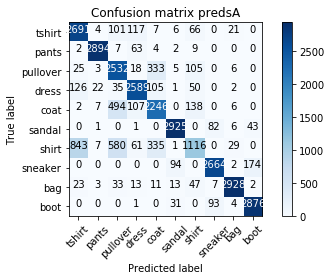

Confusion matrix, without normalization
[[2686    9   89  136   14   11   42    0   25    1]
 [  10 2876   10   74    7    1    3    0    0    0]
 [  40    4 2350   22  462    8  131    0   10    0]
 [ 160   35   26 2520  141    1   43    0    4    0]
 [  10    9  423  106 2310    0  131    0   11    0]
 [   0    1    0    1    0 2677    0  247   28  104]
 [ 909   10  559   69  476    1  916    0   32    0]
 [   0    0    0    0    0   35    0 2647    3  249]
 [  18    6   68   15   21   20   35    9 2887    1]
 [   0    0    0    0    0    7    0  113    4 2881]]


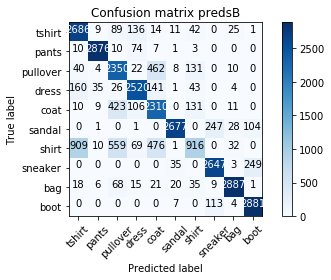

In [89]:
true = loaderA.dataset.dataset.train_labels[loaderA.dataset.indices].cpu().numpy()
cm = confusion_matrix(true, predsA, labels=range(10))
plot_confusion_matrix(cm, classes=fmnist_labels, normalize=False, title="Confusion matrix predsA")
plt.show()

cm = confusion_matrix(true, predsB, labels=range(10))
plot_confusion_matrix(cm, classes=fmnist_labels, normalize=False, title="Confusion matrix predsB")

In [87]:
print("True/PredsA: {:.3f}".format(prediction_similarity(true, predsA)))
print("True/PredsB: {:.3f}".format(prediction_similarity(true, predsB)))
print("PredsA/PredsB: {:.3f}".format(prediction_similarity(predsA, predsB)))

True/PredsA: 0.849
True/PredsB: 0.825
PredsA/PredsB: 0.932


In [83]:
print(true)
print(predsA)

[1 9 3 ... 3 7 8]
[[1]
 [9]
 [3]
 ...
 [4]
 [7]
 [3]]


In [48]:
experiments_dir = './experiments_reverse_accuracy_v8'

n_epochs = 10

min_samples = 100
min_pct = min_samples / len(mnist_train)
max_pct = 0.5
print("min_pct: {:.3f}".format(min_pct))

pcts = np.logspace(np.log10(min_pct), np.log10(max_pct), num=10, base=10)
print("pcts: {}".format(pcts))

for pct in pcts:
    print("experimenting with pct={}".format(pct))
    config = {
        'n_epochs': n_epochs,
        'pct': pct
    }
    with Experiment(config=config, experiments_dir=experiments_dir) as experiment:
        config = experiment.config
        acc1, acc3 = get_reverse_accuracy(pct=config.pct, n_epochs=config.n_epochs)

        experiment.register_result("acc1", acc1)
        experiment.register_result("acc3", acc3)

min_pct: 0.002
pcts: [0.00166667 0.00314112 0.00591998 0.01115722 0.02102769 0.03963029
 0.07469008 0.14076627 0.2652982  0.5       ]
experimenting with pct=0.0016666666666666674
data_A: 100, data_B: 59900

Test set: Avg. loss: 2.0665, Accuracy: 43/100 (43.00%)


Test set: Avg. loss: 19.8517, Accuracy: 46/100 (46.00%)

experimenting with pct=0.0031411193964051994
data_A: 188, data_B: 59812

Test set: Avg. loss: 1.5163, Accuracy: 90/188 (47.87%)


Test set: Avg. loss: 10.2506, Accuracy: 90/188 (47.87%)

experimenting with pct=0.005919978637483781
data_A: 355, data_B: 59645

Test set: Avg. loss: 0.9749, Accuracy: 247/355 (69.58%)


Test set: Avg. loss: 2.1857, Accuracy: 243/355 (68.45%)

experimenting with pct=0.011157215834702833
data_A: 669, data_B: 59331

Test set: Avg. loss: 0.7060, Accuracy: 502/669 (75.04%)


Test set: Avg. loss: 1.6647, Accuracy: 510/669 (76.23%)

experimenting with pct=0.021027688240958565
data_A: 1261, data_B: 58739

Test set: Avg. loss: 0.6339, Accuracy: 969/12

In [49]:
min_samples = 30
min_pct = min_samples / len(mnist_train)
max_pct = 0.5
print("min_pct: {:.3f}".format(min_pct))

np.logspace(np.log10(min_pct), np.log10(max_pct), num=10, )

min_pct: 0.001


array([5.00000000e-04, 1.07721735e-03, 2.32079442e-03, 5.00000000e-03,
       1.07721735e-02, 2.32079442e-02, 5.00000000e-02, 1.07721735e-01,
       2.32079442e-01, 5.00000000e-01])

In [11]:
60000 * 10e-6

0.6000000000000001